In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk
from pandas.plotting import scatter_matrix
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedShuffleSplit, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

### Exercise 1

In [2]:
DATA_PATH = '../datasets/housing/housing.csv'
housing = pd.read_csv(DATA_PATH)

In [31]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [3]:
housing['income_cat'] = pd.cut(housing['median_income'], 
                               bins=[0,2,4,6,8,10,np.inf],
                               labels=[1,2,3,4,5,6])

In [34]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_cat
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,5
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,5
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,4
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,3
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,2


In [39]:
housing.shape

(20640, 11)

In [4]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for i_train,i_test in split.split(housing, housing['income_cat']):
    strat_train = housing.loc[i_train]
    strat_test = housing.loc[i_test]

In [40]:
strat_train.shape

(16512, 11)

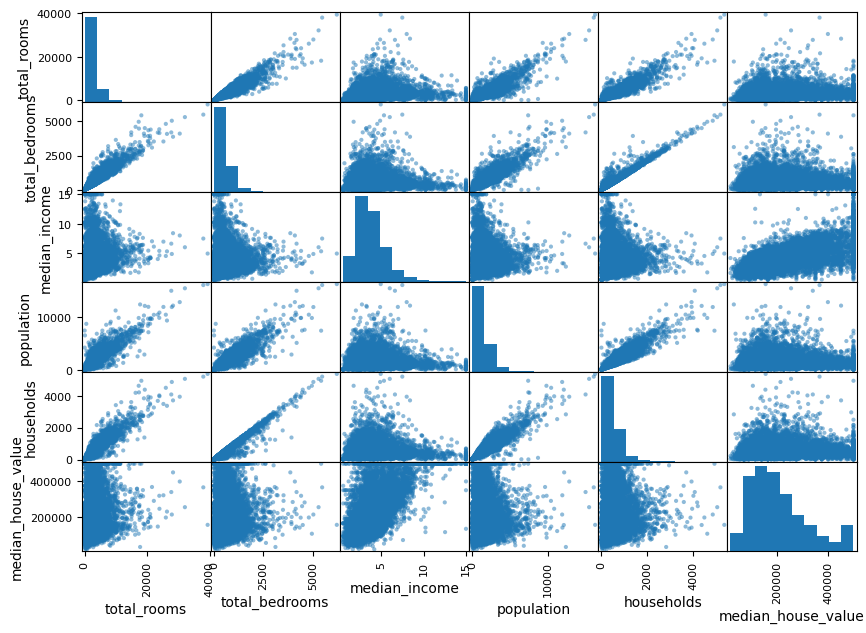

In [5]:
attributes = ['total_rooms', 'total_bedrooms','median_income', 'population', 'households', 'median_house_value']
scatter_matrix(strat_train[attributes], figsize=(10,7))
plt.show()

In [6]:
X_train = strat_train.copy()
X_train = X_train.drop('median_house_value', axis=1)
y_train = strat_train['median_house_value'].copy()

In [7]:
X_train_num = X_train.drop('ocean_proximity', axis=1)

In [8]:
imputer = SimpleImputer(strategy='median')

In [9]:
imputer.fit(X_train_num)

SimpleImputer(strategy='median')

In [10]:
X_train_num['total_bedrooms'].isna().value_counts()

False    16344
True       168
Name: total_bedrooms, dtype: int64

In [70]:
imputer.statistics_

array([-1.1849e+02,  3.4260e+01,  2.9000e+01,  2.1340e+03,  4.3600e+02,
        1.1705e+03,  4.1000e+02,  3.5417e+00,  2.0000e+00])

In [11]:
X_train_num_imp = imputer.transform(X_train_num)

In [12]:
X_train_num_imp_pd = pd.DataFrame(X_train_num_imp, columns=X_train_num.columns)
X_train_num_imp_pd['total_bedrooms'].isna().value_counts()

False    16512
Name: total_bedrooms, dtype: int64

In [13]:
ordinal_encoder = OrdinalEncoder()

In [14]:
X_train_cat = X_train[['ocean_proximity']]
X_train_cat.head(10)

,ocean_proximity
6802,<1H OCEAN
2867,INLAND
3239,INLAND
16447,INLAND
17312,<1H OCEAN
16475,INLAND
2433,INLAND
16145,NEAR BAY
3995,<1H OCEAN
12506,INLAND


In [15]:
X_train_cat_encoded = ordinal_encoder.fit_transform(X_train_cat)
X_train_cat_encoded

array([[0.],
       [1.],
       [1.],
       ...,
       [4.],
       [4.],
       [0.]])

In [93]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [16]:
one_hot = OneHotEncoder()

In [17]:
X_train_cat_one_hot = one_hot.fit_transform(X_train_cat_encoded)
X_train_cat_one_hot.toarray()

array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.]])

In [18]:
scale_std = StandardScaler()

In [19]:
X_train_std = scale_std.fit_transform(X_train_num_imp)

In [20]:
X_train_cat_one_hot = X_train_cat_one_hot.toarray()

In [21]:
X_train = np.hstack((X_train_std, X_train_cat_one_hot))

In [201]:
# X_train_cat.value_counts()
# X_test_cat.value_counts()

ocean_proximity
<1H OCEAN          7292
INLAND             5248
NEAR OCEAN         2117
NEAR BAY           1850
ISLAND                5
dtype: int64

In [22]:
X_test = strat_test.copy()
X_test = X_test.drop('median_house_value', axis=1)
y_test = strat_test['median_house_value'].copy()

X_test_num = X_test.drop('ocean_proximity', axis=1)

imputer.fit(X_test_num)

X_test_num_imp = imputer.transform(X_test_num)

X_test_cat = X_test[['ocean_proximity']]

X_test_cat_encoded = ordinal_encoder.transform(X_test_cat)

X_test_cat_one_hot = one_hot.transform(X_test_cat_encoded)

X_test_std = scale_std.transform(X_test_num_imp)

X_test_cat_one_hot = X_test_cat_one_hot.toarray()

X_test = np.hstack((X_test_std, X_test_cat_one_hot))

In [140]:
lin_reg = LinearRegression()

In [141]:
lin_reg.fit(X_train, y_train)

LinearRegression()

In [145]:
print(f'Predicions: \n{lin_reg.predict(X_train)[:5]}')
print(f'Target: \n{y_train[:5]}')

Predicions: 
[184566.46947419 112504.20841614 145033.64236321 160231.65998514
 206931.05623064]
Target: 
6802     219000.0
2867      62800.0
3239      64700.0
16447     99500.0
17312     62100.0
Name: median_house_value, dtype: float64


In [148]:
prediction = lin_reg.predict(X_train)
lin_mse = mean_squared_error(y_train, prediction)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68387.1004941367

In [150]:
lin_scores = cross_val_score(lin_reg, X_train, y_train, scoring='neg_mean_squared_error', cv=10)
lin_scores_rmse = np.sqrt(-lin_scores)
lin_scores_rmse

array([71527.95562969, 66995.53041641, 68383.3343139 , 66285.07732492,
       66916.31327018, 66458.13958603, 71311.25348418, 69289.03018818,
       69244.42355207, 68022.47620219])

In [151]:
svr_reg = SVR()

In [152]:
svr_reg.fit(X_train, y_train)

SVR()

In [153]:
svr_predictions = svr_reg.predict(X_train)

In [154]:
svr_mse = mean_squared_error(y_train, svr_predictions)
svr_rmse = np.sqrt(svr_mse)
svr_rmse

118031.63212115945

In [155]:
svr_scores = cross_val_score(svr_reg, X_train, y_train,
                             scoring='neg_mean_squared_error', cv=10)
svr_scores_rmse = np.sqrt(-svr_scores)

In [156]:
print('Scores:', svr_scores_rmse)
print('Mean:', svr_scores_rmse.mean())
print('STD:',svr_scores_rmse.std())

Scores: [120404.75324952 118451.92683482 118175.87714898 114668.78465642
 115566.05776472 120086.78918039 118169.60154216 123103.30446121
 114970.72371221 116917.16853343]
Mean: 118051.49870838551
STD: 2525.6438214832006


In [157]:
param_grid = [{'kernel':['rbf'], 'C':[0.1,0.5,1,3], 'gamma':['scale','auto']}]

grid_svr = GridSearchCV(svr_reg, param_grid, cv=2, 
                        scoring='neg_mean_squared_error',
                        return_train_score=True)

grid_svr.fit(X_train, y_train)

GridSearchCV(cv=2, estimator=SVR(),
             param_grid=[{'C': [0.1, 0.5, 1, 3], 'gamma': ['scale', 'auto'],
                          'kernel': ['rbf']}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [158]:
grid_svr.best_params_

{'C': 3, 'gamma': 'auto', 'kernel': 'rbf'}

In [ ]:
grid_svr.best_estimator_

In [163]:
cv_res_svr = grid_svr.cv_results_

for mean_score, params in zip(cv_res_svr['mean_test_score'], cv_res_svr['params']):
    print(np.sqrt(-mean_score), params)

118476.77821103575 {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
118475.78215128559 {'C': 0.1, 'gamma': 'auto', 'kernel': 'rbf'}
118376.75104761396 {'C': 0.5, 'gamma': 'scale', 'kernel': 'rbf'}
118371.0174553284 {'C': 0.5, 'gamma': 'auto', 'kernel': 'rbf'}
118263.77982196693 {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
118253.68757160877 {'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}
117806.46495315747 {'C': 3, 'gamma': 'scale', 'kernel': 'rbf'}
117780.82206862996 {'C': 3, 'gamma': 'auto', 'kernel': 'rbf'}


In [166]:
svr_final_model = grid_svr.best_estimator_

In [178]:
X_train.shape

(16512, 14)

In [208]:
svr_pred = svr_final_model.predict(X_test)

In [209]:
final_svr_mse = mean_squared_error(y_test, svr_pred)
final_svr_rmse = np.sqrt(final_svr_mse)

print(final_svr_rmse)

117504.85883191452


### Exercise 2

In [213]:
param_d = [{'kernel':['rbf'], 'C':[0.1,1,3,5,7,9,12,15,18], 'gamma':['scale','auto']}]

rand_svr = RandomizedSearchCV(svr_reg, param_d, cv=2, 
                        scoring='neg_mean_squared_error',
                        return_train_score=True)

rand_svr.fit(X_train, y_train)

RandomizedSearchCV(cv=2, estimator=SVR(),
                   param_distributions=[{'C': [0.1, 1, 3, 5, 7, 9, 12, 15, 18],
                                         'gamma': ['scale', 'auto'],
                                         'kernel': ['rbf']}],
                   return_train_score=True, scoring='neg_mean_squared_error')

In [217]:
rand_svr.best_params_

{'kernel': 'rbf', 'gamma': 'auto', 'C': 18}

In [214]:
rand_svr_final = rand_svr.best_estimator_

In [215]:
rand_svr_pred = rand_svr_final.predict(X_test)

In [216]:
rand_svr_mse = mean_squared_error(y_test, rand_svr_pred)
rand_svr_rmse = np.sqrt(rand_svr_mse)
print(rand_svr_rmse)

111213.21577058684


### Exercise 3

In [113]:
from sklearn.base import BaseEstimator, TransformerMixin

class ImportantAttributes(BaseEstimator, TransformerMixin):
    def __init__(self, test=False):
        self.test = test

    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        forest_reg = RandomForestRegressor()

        param_grid = [{'n_estimators': [3, 30, 50], 'max_features': [2, 8, 12]},
                    {'bootstrap': [False], 'n_estimators': [3, 10, 20], 'max_features': [2, 4]},]

        forest_reg = RandomForestRegressor()

        grid_search = GridSearchCV(forest_reg, param_grid, cv=2,
                                    scoring='neg_mean_squared_error',
                                    return_train_score=True)
        grid_search.fit(X_train, y_train)

        cv_res = grid_search.cv_results_

        for mean_score, params in zip(cv_res['mean_test_score'], cv_res['params']):
            print(np.sqrt(-mean_score), params)

        feature_importances = grid_search.best_estimator_.feature_importances_
        
        # feature_importances = sorted(feature_importances, reverse=True)

        return feature_importances, np.argsort(feature_importances)

imp_att = ImportantAttributes(test=False)
fea_imp = imp_att.transform(X_train)

In [106]:
imp, id_import = fea_imp

X_train_pd = strat_train.copy()
X_train_cat_pd = pd.get_dummies(X_train_cat)
X_train_cat_pd.columns

columns = np.concatenate((X_train_pd.columns, X_train_cat_pd.columns))
i = 0
for c in columns[np.flip(id_import)]:
    i += 1
    print(i, c, r'- %.2f'%imp[np.flip(id_import)][i-1])

1 median_income - 0.43
2 income_cat - 0.14
3 longitude - 0.11
4 latitude - 0.10
5 housing_median_age - 0.05
6 median_house_value - 0.05
7 population - 0.03
8 total_rooms - 0.03
9 total_bedrooms - 0.02
10 households - 0.02
11 ocean_proximity_ISLAND - 0.01
12 ocean_proximity - 0.00
13 ocean_proximity_INLAND - 0.00
14 ocean_proximity_<1H OCEAN - 0.00


### Exercise 4

In [118]:

class Prediction(BaseEstimator, TransformerMixin):
    def __init__(self, test=False):
        self.test = test

    def fit(self):
        return self
    
    def predict(self, X, y):
        lin_reg = LinearRegression()
        lin_reg.fit(X, y)
        prediction = lin_reg.predict(X)
        return prediction

In [ ]:
pipeline = Pipeline([('imputer', SimpleImputer(strategy='median'),
                      ('std_scaler', StandardScaler()),
                      ('select_attribs', ImportantAttributes()),
                      ('predict', Prediction()))])

pipeline.fit(X_train, y_train)